## 0. Load Data

In [1]:
dataname = 'abalone'

In [2]:
from scipy.io import loadmat
import numpy as np
import pandas as pd
df = pd.read_csv('../datasets/OD/%s/meta_data/%s.original.csv'%(dataname, dataname))
gt = pd.read_csv('../datasets/OD/%s/meta_data/%s.diff.csv'%(dataname, dataname))['ground.truth']
gt_idx = gt.index.values[gt == 'anomaly']

In [3]:
df.head()

,Y,F1,V1,V2,V3,V4,V5,V6,V7
0,15,M,0.455,0.365,0.095,0.5140,0.2245,0.1010,0.150
1,7,M,0.350,0.265,0.090,0.2255,0.0995,0.0485,0.070
2,9,F,0.530,0.420,0.135,0.6770,0.2565,0.1415,0.210
3,10,M,0.440,0.365,0.125,0.5160,0.2155,0.1140,0.155
4,7,I,0.330,0.255,0.080,0.2050,0.0895,0.0395,0.055


In [4]:
from profiler.core import *

## 1. Instantiate Engine
* workers : number of processes
* tol     : tolerance for differences when creating training data (set to 0 if data is completely clean)
* eps     : error bound for inverse covariance estimation (since we use conservative calculation when determining minimum sample size, we recommend to set eps <= 0.01)
* embedtxt: if set to true, differentiate b/w textual data and categorical data, and use word embedding for the former

In [5]:
pf = Profiler(workers=2, tol=1e-6, eps=0.05, embedtxt=False)

## 2. Load Data
* name: any name you like
* src: \[FILE; DF; DB (not implemented)\]
* fpath: required if src == FILE
* df: required if src == DF
* check_param: print parameters used for data loading

In [6]:
pf.session.load_data(src=DF, df=df, check_param=True)

INFO:profiler.utility:[0.007871866226196289] Load Data start

INFO:profiler.data.dataset:parameters used for data loading:
 {'na_values': {'', 'unknown', 'None', 'nan', 'none', '?', 'NaN'}, 'sep': ',', 'header': 'infer', 'dropcol': None, 'dropna': False, 'encoding': 'utf-8', 'normalize': True, 'min_categories_for_embedding': 10}
INFO:profiler.data.dataset:inferred types of attributes: {
    "Y": "numeric",
    "F1": "categorical",
    "V1": "numeric",
    "V2": "numeric",
    "V3": "numeric",
    "V4": "numeric",
    "V5": "numeric",
    "V6": "numeric",
    "V7": "numeric"
}
INFO:profiler.data.dataset:(possible types: numeric, categorical, text, date)
INFO:profiler.data.dataset:inferred operators of attributes: {'Y': ['equal'], 'F1': ['equal'], 'V1': ['equal'], 'V2': ['equal'], 'V3': ['equal'], 'V4': ['equal'], 'V5': ['equal'], 'V6': ['equal'], 'V7': ['equal']}
INFO:profiler.data.dataset:(possible operators: equal, notequal, greater_than, less_than)
INFO:profiler.utility:[0.0239078998

### 2.1 Change Data Types of Attributes
* required input:
    * a list of attributes
    * a list of data types (must match the order of the attributes; can be CATEGORICAL, NUMERIC, TEXT, DATE)
* optional input:
    * a list of regular expression extractor

In [7]:

# pf.session.change_dtypes(['ProviderNumber', 'ZipCode', 'PhoneNumber', 'State', 'EmergencyService','Score', 'Sample'], 
#                             [CATEGORICAL, NUMERIC, CATEGORICAL, TEXT, TEXT, NUMERIC, NUMERIC],
#                             [None, None, None, None, None, r'(\d+)%', r'(\d+)\spatients'])

### 2.2. Load/Train Embeddings for TEXT
* path: path to saved/to-save embedding folder
* load: set to true -- load saved vec from 'path'; set to false -- train locally
* save: (only for load = False) save trained vectors to 'path'

In [8]:
#pf.session.load_embedding(save=True, path='data/hospital/', load=True)

## 3. Load Training Data
* multiplier: if set to None, will infer the minimal sample size; otherwise, it will create (# samples) * (# attributes) * (multiplier) training samples

In [9]:
pf.session.load_training_data(multiplier = None)

INFO:profiler.utility:[0.045903921127319336] Create Training Data start

INFO:profiler.data.transformer:needs multiplier = 9 to bound the error in inv cov estimation <= 0.05000000
INFO:profiler.data.transformer:use multiplier = 9, and the bound is 0.00017033
INFO:profiler.data.transformer:Draw Pairs
100%|██████████| 9/9 [00:00<00:00, 279.33it/s]
INFO:profiler.data.transformer:Number of training samples: 37593
INFO:profiler.data.transformer:Computing Differences
INFO:profiler.data.transformer:estimated missing data probability in training data is 0.0000
INFO:profiler.utility:[0.17586779594421387] Create Training Data execution time: 0.12996387481689453



## 4. Learn Structure
* sparsity: intensity of L1-regularizer in inverse covariance estimation (glasso)
* take_neg: if set to true, consider equal -> equal only

In [10]:
autoregress_matrix = pf.session.learn_structure(sparsity=0,
                                                infer_order=True)

INFO:profiler.utility:[0.18318581581115723] Learn Structure start

INFO:profiler.learner:use threshold 0.0688
INFO:profiler.utility:[0.32170701026916504] Learn Structure execution time: 0.1385211944580078



* score: 
    * "fit_error": mse for fitting y = B'X + c for each atttribute y 
    * "training_data_fd_vio_ratio": the higher the score, the more violations of FDs in the training data. (bounded: \[0,1\])

In [11]:
parent_sets = pf.session.get_dependencies(score="fit_error")


INFO:profiler.utility:[0.3274507522583008] Get Dependencies start

INFO:profiler.utility:[0.3390200138092041] Get Dependencies execution time: 0.01156926155090332



V1 -> V2 (0.13934960821999404)


## 5. Visualization

In [12]:
pf.session.visualize_covariance()

<Figure size 1000x800 with 2 Axes>

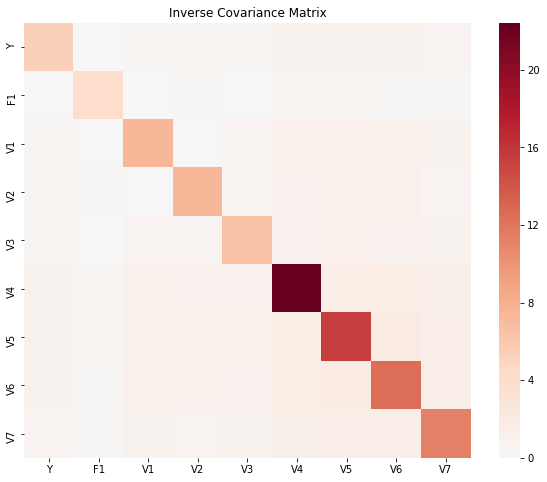

In [13]:
pf.session.visualize_inverse_covariance()

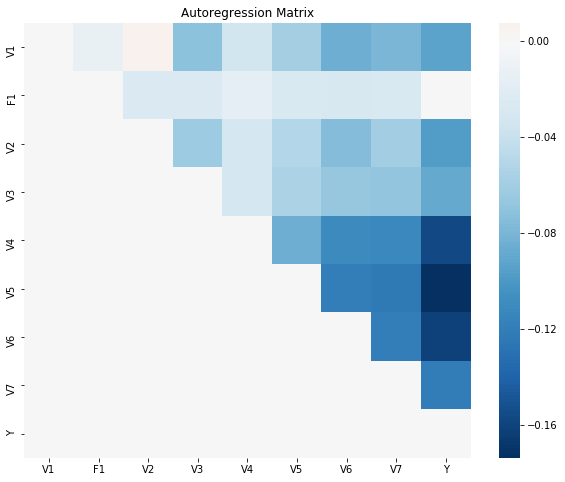

In [14]:
pf.session.visualize_autoregression()

In [15]:
pf.session.timer.get_stat()


,time_point,msg,execution_time
0,0.007872,start: Load Data,0.000000
1,0.023908,end: Load Data,0.016036
2,0.045904,start: Create Training Data,0.000000
3,0.175868,end: Create Training Data,0.129964
4,0.183186,start: Learn Structure,0.000000
5,0.321707,end: Learn Structure,0.138521
6,0.327451,start: Get Dependencies,0.000000
7,0.339020,end: Get Dependencies,0.011569
8,0.339020,total_execution_time,0.296090


In [16]:
from profiler.app.od import *

INFO:profiler.utility:[0.000827789306640625] naive start

INFO:profiler.utility:[0.8182508945465088] naive execution time: 0.8174231052398682

INFO:profiler.utility:[0.8195850849151611] structured start

100%|██████████| 9/9 [00:04<00:00,  1.82it/s]
INFO:profiler.utility:[5.770409822463989] structured execution time: 4.950824737548828



   time_point                   msg  execution_time
0    0.000828          start: naive        0.000000
1    0.818251            end: naive        0.817423
2    0.819585     start: structured        0.000000
3    5.770410       end: structured        4.950825
4    5.770410  total_execution_time        5.768248
Results for naive approach:
with 3408 detected outliers, precision is: 0.5552
with 6882 detected outliers, recall is: 0.9092
f1: 0.6894
Results for structure only:
with 83 detected outliers, precision is: 0.5301
with 83 detected outliers, recall is: 0.0211
f1: 0.0407
Results for enhance naive with structured:
with 3426 detected outliers, precision is: 0.5543
with 6965 detected outliers, recall is: 0.9125
f1: 0.6897


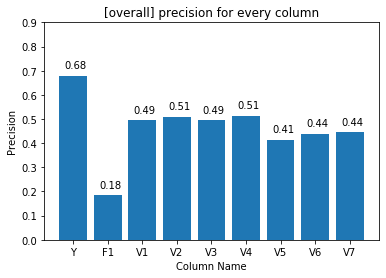

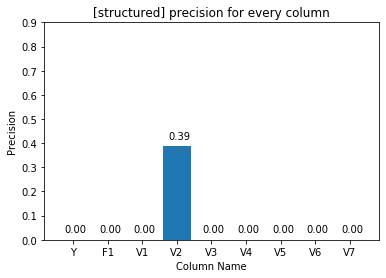

In [17]:
detector = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="ocsvm", gt_idx=gt_idx,
                           nu=0.1, gamma='auto', tol=0.01, t=0.05, knn=True, neighbor_size=200)
detector.run_all(parent_sets)
detector.evaluate()

INFO:profiler.utility:[0.00045680999755859375] naive start

INFO:profiler.utility:[0.4659090042114258] naive execution time: 0.4654521942138672

INFO:profiler.utility:[0.46655893325805664] structured start

100%|██████████| 9/9 [00:10<00:00,  1.20s/it]
INFO:profiler.utility:[11.272148847579956] structured execution time: 10.8055899143219



   time_point                   msg  execution_time
0    0.000457          start: naive        0.000000
1    0.465909            end: naive        0.465452
2    0.466559     start: structured        0.000000
3   11.272149       end: structured       10.805590
4   11.272149  total_execution_time       11.271042
Results for naive approach:
with 1809 detected outliers, precision is: 0.5290
with 3158 detected outliers, recall is: 0.4599
f1: 0.4920
Results for structure only:
with 58 detected outliers, precision is: 0.5172
with 58 detected outliers, recall is: 0.0144
f1: 0.0281
Results for enhance naive with structured:
with 1847 detected outliers, precision is: 0.5273
with 3216 detected outliers, recall is: 0.4680
f1: 0.4959


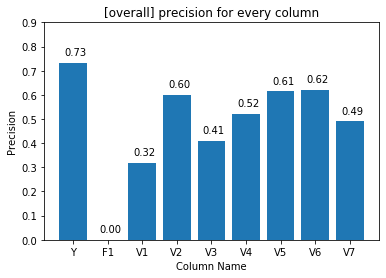

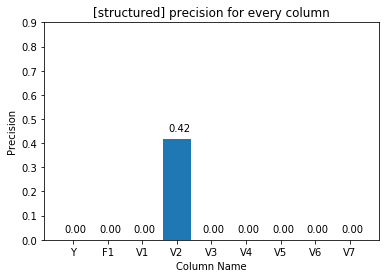

In [18]:
detector = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="lof", gt_idx=gt_idx,
                          tol=0.01, t=0.05, knn=True, neighbor_size=200)
detector.run_all(parent_sets)
detector.evaluate()

INFO:profiler.utility:[0.0006039142608642578] naive start

INFO:profiler.utility:[3.490708827972412] naive execution time: 3.490104913711548

INFO:profiler.utility:[3.4915168285369873] structured start


100%|██████████| 9/9 [12:45<00:00, 85.04s/it] 
INFO:profiler.utility:[768.820867061615] structured execution time: 765.329350233078



   time_point                   msg  execution_time
0    0.000604          start: naive        0.000000
1    3.490709            end: naive        3.490105
2    3.491517     start: structured        0.000000
3  768.820867       end: structured      765.329350
4  768.820867  total_execution_time      768.819455
Results for naive approach:
with 1026 detected outliers, precision is: 0.6296
with 3250 detected outliers, recall is: 0.3104
f1: 0.4158
Results for structure only:
with 50 detected outliers, precision is: 0.5800
with 50 detected outliers, recall is: 0.0139
f1: 0.0272
Results for enhance naive with structured:
with 1066 detected outliers, precision is: 0.6238
with 3300 detected outliers, recall is: 0.3196
f1: 0.4226


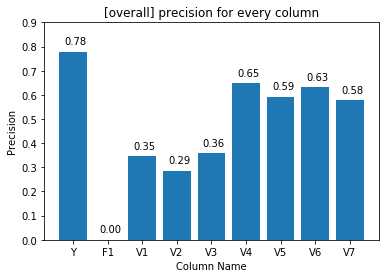

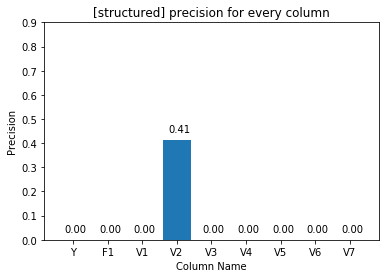

In [20]:
detector = ScikitDetector(pf.session.ds.df, attr=pf.session.ds.dtypes, method="isf", gt_idx=gt_idx,
                          tol=0.01, t=0.05, knn=True, neighbor_size=200)
detector.run_all(parent_sets)
detector.evaluate()